# Slice & preprocess the REU data (3D vars include) for ML tasks
**Authors: Yu Huang, Sungduk Yu, Julius Busecke**

Approximate run time for this notebook:

* 10min (32G mem & 4CPU) for calculating daily mean of one 2D variable and one 3D variable from the original 10-yr 20-min time step data

GitHub repository links: [tutorials for REU dataset](https://github.com/sungdukyu/LEAP_REU_Dataset_Notebook); [LEAP-REU23 Bootcamp](https://github.com/leap-stc/LEAP-bootcamps).


### Install and load python packages

We use [mamba](https://mamba.readthedocs.io/en/latest/installation.html) (instead of conda) to install packages on Hub. Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [1]:
# ! mamba install -y pynco pynio pyngl

In [2]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime

### Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [3]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [4]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Open the file you want using xarray


Sammy's code to load in variables, add the time dimension, etc.

In [5]:
input_vars = ['state_ps', 'pbuf_LHFLX', 'state_q0001', 'state_t']
output_vars = ['state_q0001']

In [6]:
%%time
def load_vars_xarray(input_vars, output_vars, downsample=False, chunks = True):
    # raw files, not interpolated according to Yu suggestion
    if(chunks):
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        inp = xr.open_dataset(mapper, engine='zarr', chunks={})
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        output = xr.open_dataset(mapper, engine='zarr', chunks={'sample':720})
    else:
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        inp = xr.open_dataset(mapper, engine='zarr')
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        output = xr.open_dataset(mapper, engine='zarr')
    if downsample: # might as well do first
        inp = inp.isel(sample = np.arange(36,len(inp.sample),72)) #  every 1 day
        output = output.isel(sample = np.arange(36,len(output.sample),72))
    ds = inp[input_vars]
    for var in output_vars:
        ds['out_'+var] = output[var]

    time = pd.DataFrame({"ymd":inp.ymd, "tod":inp.tod})
    # rename sample to reformatted time column 
    f = lambda ymd, tod : cftime.DatetimeNoLeap(ymd//10000, ymd%10000//100, ymd%10000%100, tod // 3600, tod%3600 // 60)
    time = time.apply(lambda x: f(x.ymd, x.tod), axis=1)
    ds['sample'] = list(time)
    ds = ds.rename({'sample':'time'})
    ds = ds.assign_coords({'ncol' : ds.ncol})
    return(ds)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [7]:
ds = load_vars_xarray(input_vars, output_vars)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [8]:
# do the transformation so we have: total precipitation = snow + rainfall

#ds = ds[['cam_out_PRECT', 'cam_out_NETSW']].resample(time='1M').mean(dim='time')
ds

<xarray.Dataset>
Dimensions:          (time: 210240, ncol: 384, lev: 60)
Coordinates:
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
  * ncol             (ncol) int64 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
Dimensions without coordinates: lev
Data variables:
    state_ps         (time, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    pbuf_LHFLX       (time, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    state_q0001      (time, lev, ncol) float64 dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    state_t          (time, lev, ncol) float64 dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    out_state_q0001  (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Convert the dimension/coordinate of column index to structured lat, lon 

#### Open a file that stores grid information, and check the original lat, lon information

In [9]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

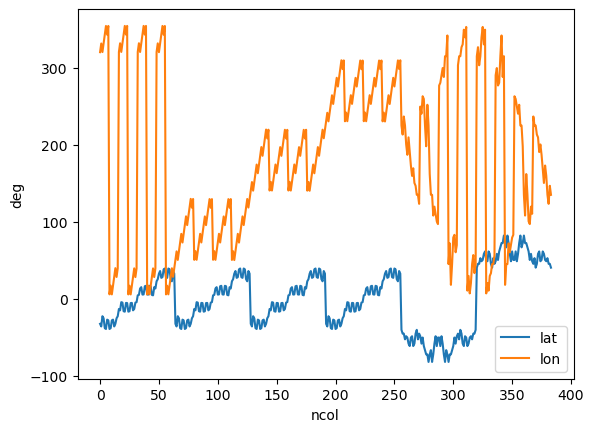

In [10]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [11]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Change the geo-coordinate from column index to multi-index (lat, lon) 

In [12]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = ds.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# use multi-index and unstack function to convert the 1D dimension/coordinate ncol to 2D lat and lon
ds_multiindex['index_id'] = ds_multiindex.coords['ncol'].copy()
ds_multiindex.coords['ncol'] = pd.MultiIndex.from_arrays([lat, lon], names=['lat', 'lon'])
ds_multiindex = ds_multiindex.unstack('ncol')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [13]:
ds_multiindex

<xarray.Dataset>
Dimensions:          (lat: 52, lon: 180, time: 210240, lev: 60)
Coordinates:
  * lat              (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
  * lon              (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: lev
Data variables:
    state_ps         (time, lat, lon) float64 dask.array<chunksize=(1512, 52, 180), meta=np.ndarray>
    pbuf_LHFLX       (time, lat, lon) float64 dask.array<chunksize=(1512, 52, 180), meta=np.ndarray>
    state_q0001      (time, lev, lat, lon) float64 dask.array<chunksize=(1512, 60, 52, 180), meta=np.ndarray>
    state_t          (time, lev, lat, lon) float64 dask.array<chunksize=(1512, 60, 52, 180), meta=np.ndarray>
    out_state_q0001  (time, lev, lat, lon) float64 dask.array<chunksize=(720, 60, 52, 180), meta=np.ndarray>
    index_id         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

#### Select the domain and unstack variables as wanted

In [14]:
# slice the data as wanted, only keep the variables and domain that you're interested in
# here I only keep the data within \pm 45 degree in lat
ds_sel = ds_multiindex[['state_ps', 'pbuf_LHFLX', 'state_q0001', 'state_t', 'index_id','out_state_q0001']].sel(lat = slice(-10,0),lon = slice(300,310))
#ds_sel
ds_sel

<xarray.Dataset>
Dimensions:          (time: 210240, lat: 4, lon: 5, lev: 60)
Coordinates:
  * lat              (lat) float64 -5.61 -5.41 -5.01 -4.43
  * lon              (lon) float64 303.3 309.4 309.5 309.6 309.7
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: lev
Data variables:
    state_ps         (time, lat, lon) float64 dask.array<chunksize=(1512, 4, 5), meta=np.ndarray>
    pbuf_LHFLX       (time, lat, lon) float64 dask.array<chunksize=(1512, 4, 5), meta=np.ndarray>
    state_q0001      (time, lev, lat, lon) float64 dask.array<chunksize=(1512, 60, 4, 5), meta=np.ndarray>
    state_t          (time, lev, lat, lon) float64 dask.array<chunksize=(1512, 60, 4, 5), meta=np.ndarray>
    index_id         (lat, lon) float64 nan nan nan nan ... 223.0 nan nan nan
    out_state_q0001  (time, lev, lat, lon) float64 dask.array<chunksize=(720, 60, 4, 5), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

For ML purpose, we treat each column on each day as one sample entry, so it's better NOT to convert the dimension to lat and lon for ML tasks, because it will increase the dimension size and lead to many NaNs.

Instead, we want to select data based on lat and lon information, but use original column index as the data dimension.

In [15]:
# get the column index from the above dataset
iid = ds_sel.index_id.values
iid = iid[~np.isnan(iid)].astype(int)
print(iid)
ds_sel2 = ds.sel(ncol = iid)
ds_sel2

[223]


<xarray.Dataset>
Dimensions:          (time: 210240, ncol: 1, lev: 60)
Coordinates:
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
  * ncol             (ncol) int64 223
Dimensions without coordinates: lev
Data variables:
    state_ps         (time, ncol) float64 dask.array<chunksize=(1512, 1), meta=np.ndarray>
    pbuf_LHFLX       (time, ncol) float64 dask.array<chunksize=(1512, 1), meta=np.ndarray>
    state_q0001      (time, lev, ncol) float64 dask.array<chunksize=(1512, 60, 1), meta=np.ndarray>
    state_t          (time, lev, ncol) float64 dask.array<chunksize=(1512, 60, 1), meta=np.ndarray>
    out_state_q0001  (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 1), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

# calculating dz for a single month: ds_sel3

In [16]:
# #sammy's code to downsample code
# downsample = False
# if downsample:
#     yeet = ds.isel(time=np.arange(0, len(ds.time), 72))

In [17]:
#selecting only one year
ds_sel3 = ds_sel2.sel(time='0001-07')
ds_sel3

<xarray.Dataset>
Dimensions:          (time: 2232, ncol: 1, lev: 60)
Coordinates:
  * time             (time) object 0001-07-01 00:00:00 ... 0001-07-31 23:40:00
  * ncol             (ncol) int64 223
Dimensions without coordinates: lev
Data variables:
    state_ps         (time, ncol) float64 dask.array<chunksize=(1296, 1), meta=np.ndarray>
    pbuf_LHFLX       (time, ncol) float64 dask.array<chunksize=(1296, 1), meta=np.ndarray>
    state_q0001      (time, lev, ncol) float64 dask.array<chunksize=(1296, 60, 1), meta=np.ndarray>
    state_t          (time, lev, ncol) float64 dask.array<chunksize=(1296, 60, 1), meta=np.ndarray>
    out_state_q0001  (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 1), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### pressure calculation

In [18]:
#calculates the pressure at all levels
pressure = (ds_grid.hyam * ds_grid.P0) + (ds_grid.hybm * ds_sel3.state_ps)
#pressure.values

In [19]:
#calculate the change in log of pressure between levels
log_pressure = []
for level in range(0,59):
    log_ps_i = np.log(pressure.sel(lev = level))
    log_ps_i1 = np.log(pressure.sel(lev = level +1))
    diff = log_ps_i - log_ps_i1
    log_pressure.append(diff)
log_pressure = np.array(log_pressure)


In [20]:
log_pressure

array([[[-0.58836978],
        [-0.58836978],
        [-0.58836978],
        ...,
        [-0.58836978],
        [-0.58836978],
        [-0.58836978]],

       [[-0.58355846],
        [-0.58355846],
        [-0.58355846],
        ...,
        [-0.58355846],
        [-0.58355846],
        [-0.58355846]],

       [[-0.57449467],
        [-0.57449467],
        [-0.57449467],
        ...,
        [-0.57449467],
        [-0.57449467],
        [-0.57449467]],

       ...,

       [[-0.01483908],
        [-0.01484015],
        [-0.01484092],
        ...,
        [-0.01483013],
        [-0.01483105],
        [-0.01483199]],

       [[-0.01481834],
        [-0.0148194 ],
        [-0.01482016],
        ...,
        [-0.01480954],
        [-0.01481044],
        [-0.01481137]],

       [[-0.01481141],
        [-0.01481244],
        [-0.01481319],
        ...,
        [-0.01480273],
        [-0.01480362],
        [-0.01480454]]])

### virtual temperature calculation

In [21]:
#establish q and epsilon variables
q = ds_sel3.state_q0001
eps = .622
t = ds_sel3.state_t

In [22]:
#calculate virtual temperature using eq: T*(1-q+q/e)
virt_temp = t*(1 - q + q/eps)
#virt_temp.sel(lev = 59)

In [23]:
#virt_temp.sel(lev = 0).values

In [24]:
virt_temp.shape, log_pressure.shape

((2232, 60, 1), (59, 2232, 1))

In [25]:
virt_temp=virt_temp.transpose('lev','time', 'ncol')

In [26]:
# take the mean log temp between two layers
mean_temp = []
for i in range(0, len(virt_temp)-1):
    avg = (virt_temp[i] + virt_temp[i+1])/2
    mean_temp.append(avg)
    
mean_temp = np.array(mean_temp)
len(mean_temp)
# (virt_temp[0] + virt_temp[1])/2

59

### dz calculation

In [27]:
#establish R and g
R = 287.05
g = 9.8

In [28]:
#calculate dz
#I had to take the negative off of this one.
dz = -((R * mean_temp)/g)*log_pressure

i need to figure out what unit dz is in

In [29]:
dz.shape

(59, 2232, 1)

In [30]:
len(dz)

59

In [40]:
dz[45]

array([[223.54371451],
       [223.55229902],
       [223.51817886],
       ...,
       [224.34874994],
       [224.33782705],
       [224.33415016]])

# Height calculator using dz

In [3]:
if False:
    np.save('../variables/dz.npy', dz)
else: 
    dz = np.load('../variables/dz.npy')

In [12]:
def height(level):
    count = level
    meters = 0
    while count < 47:
        meters += dz[level]
        count += 1
    return meters 
    
level= int(input("Enter a level you want to know the height of"))
height(level)

Enter a level you want to know the height of 20


array([[23204.59212196],
       [23206.22194179],
       [23208.19251898],
       ...,
       [23308.83054638],
       [23311.36139767],
       [23313.83749774]])

# Calculating moisture flux the long way

### calculate moisture tendency between levels

In [ ]:
#import q_tend
q_tend_calc = xr.open_dataset('../variables/q_tend_train.nc')

In [ ]:
q_tend_calc.q_tend.shape

(2232, 60, 1)

In [ ]:
#assigning q_tend as variable
q_tend = q_tend_calc.q_tend

In [ ]:
#drop levels in q_tend
q_tend2 = q_tend.sel(lev = slice(12,60))

In [ ]:
#finding average q_tend between two levels
qtend_avg = []
for i in range(0, len(q_tend2.lev)-1):
    mean = (q_tend2.sel(lev = i)+q_tend2.sel(lev = i+1))/2
    qtend_avg.append(mean)
qtend_avg = np.array(qtend_avg)
qtend_avg.shape
len(qtend_avg)

47

### moisture flux calculations

In [63]:
#one part of heat flux eq
# -(((ds_sel3.q_tend.sel(lev = 50)+ds_sel3.q_tend.sel(lev = 51))/2)*dz[50]).values

In [38]:
#assign lhf as variable
lhf = ds_sel3.pbuf_LHFLX
lhf.values.shape

(2232, 1)

In [39]:
2.5*10**6

2500000.0

In [40]:
# change units of LHF
# divide LHF by rho*Lv. Then unit will be [m/s].
# rho is air density of value about 1 kg/m^3, Lv is latent heat of vaporization (2.5 *10^6 J/kg)
lhf2 = lhf/(2.5*10**6)

In [43]:
lhf.values

array([[17.25720387],
       [18.94544699],
       [20.46794659],
       ...,
       [ 1.47327117],
       [ 2.0312347 ],
       [ 2.81679807]])

In [42]:
lhf2.values

array([[6.90288155e-06],
       [7.57817880e-06],
       [8.18717864e-06],
       ...,
       [5.89308466e-07],
       [8.12493880e-07],
       [1.12671923e-06]])

In [44]:
#finding heat flux for one level near surface
(-qtend_avg[40]*dz[40]-qtend_avg[41]*dz[41]+lhf2).values

array([[ 4.20002378e-06],
       [-3.94017420e-06],
       [ 4.50619079e-06],
       ...,
       [-4.93329376e-06],
       [-1.06043985e-07],
       [ 5.05417497e-06]])

In [66]:
range(0,len(qtend_avg))

range(0, 47)

In [45]:
#calculate a w'q' for each level
wq = []
for level in range(0,len(qtend_avg)): #runs the level counter. Will determine which level you are finding w'q' for
    count = level
    flux = 0
    #this next part adds up the values and adds latent heat flux, 
    #finally finding w'q' for the given level you are on
    while count < 47: 
        tend = -qtend_avg[count]*dz[count]
        flux += tend
        count+=1
    f_lhf = flux + lhf2
    wq.append(f_lhf.values)
wq = np.array(wq)

#calculate dq/dz and check it is in same shape

In [76]:
wq.shape

(47, 2232, 1)

# dq/dz calculation

In [47]:
#getting q but just 47 levels
q = ds_sel3.out_state_q0001.sel(lev = slice(12,60))
q.shape

(2232, 48, 1)

In [48]:
q.sel(lev = 40).values-q.sel(lev = 41).values

array([[-8.34240710e-05],
       [-8.18227243e-05],
       [-9.94929995e-05],
       ...,
       [-3.20074234e-06],
       [-3.83226226e-05],
       [-4.78820242e-05]])

In [49]:
#find the difference in humidity between levels
dq = []
for i in range(0, len(q.lev)-1):
    diff = (q.sel(lev = i)-q.sel(lev = i+1))
    dq.append(diff)
dq = np.array(dq)
dq.shape

(47, 2232, 1)

In [56]:
dq.shape, dz.shape

((47, 2232, 1), (59, 2232, 1))

In [57]:
dz[slice(12,60)].shape

(47, 2232, 1)

In [58]:
#drop levels in dz
dz2 = dz[slice(12,60)]

In [59]:
dqdz = dq/dz2

In [60]:
dqdz

array([[[-4.70535844e-11],
        [-4.70816885e-11],
        [-4.71327115e-11],
        ...,
        [-4.19267726e-10],
        [-4.20085387e-10],
        [-4.21017240e-10]],

       [[-5.20840220e-11],
        [-5.20251010e-11],
        [-5.19294954e-11],
        ...,
        [-3.44810334e-11],
        [-3.53237560e-11],
        [-3.63673505e-11]],

       [[-2.39256930e-12],
        [-1.80711333e-12],
        [-1.29014552e-12],
        ...,
        [ 3.41063751e-11],
        [ 3.38073871e-11],
        [ 3.34123486e-11]],

       ...,

       [[-1.39692907e-06],
        [-1.44199577e-06],
        [-1.62596828e-06],
        ...,
        [-3.77461190e-07],
        [-3.50626406e-07],
        [-2.95616935e-07]],

       [[-1.75182537e-06],
        [-1.89657170e-06],
        [-2.38496968e-06],
        ...,
        [-6.55868403e-07],
        [-6.28111343e-07],
        [-5.27710221e-07]],

       [[-4.79809119e-06],
        [-4.90180092e-06],
        [-4.42540060e-06],
        ...,
        

In [63]:
#save non-normalized variables
if False:
    np.save('../variables/dqdz.npy', dqdz)
    np.save('../variables/wq.npy', wq)

### normalization of w'q' and dq/dz

In [49]:
dqdz.shape

NameError: name 'dqdz' is not defined

In [65]:
wq.shape

(47, 2232, 1)

In [66]:
#change order of dimensions so that matrix math can be done
wq2 = wq.transpose(1,0,2)

In [67]:
wq2.shape, (wq.mean(axis = 1)).shape, (wq.std(axis = 1)).shape

((2232, 47, 1), (47, 1), (47, 1))

In [68]:
wq_stand = (wq2 - wq.mean(axis = 1))/wq.std(axis = 1)

In [69]:
wq_stand.shape

(2232, 47, 1)

In [70]:
dqdz2 = dqdz.transpose(1,0,2)

In [71]:
dqdz2.shape, (dqdz.mean(axis = 1)).shape, (dqdz.std(axis = 1)).shape

((2232, 47, 1), (47, 1), (47, 1))

In [72]:
dqdz_stand = (dqdz2 - dqdz.mean(axis = 1))/dqdz.std(axis = 1)

In [73]:
dqdz_stand

array([[[ 1.31814786],
        [-0.79182703],
        [-0.96842623],
        ...,
        [-1.23770862],
        [-1.85056018],
        [-4.31219162]],

       [[ 1.31791509],
        [-0.79023515],
        [-0.96104231],
        ...,
        [-1.31061573],
        [-2.07805222],
        [-4.4220944 ]],

       [[ 1.31749251],
        [-0.78765215],
        [-0.95452218],
        ...,
        [-1.60823913],
        [-2.84564788],
        [-3.91724571]],

       ...,

       [[-1.76464184],
        [-0.31624325],
        [-0.50809235],
        ...,
        [ 0.41154586],
        [-0.12808827],
        [-0.1043763 ]],

       [[-1.77141395],
        [-0.33901127],
        [-0.51186326],
        ...,
        [ 0.4549581 ],
        [-0.08446361],
        [-0.20739268]],

       [[-1.77913184],
        [-0.36720629],
        [-0.51684559],
        ...,
        [ 0.54395023],
        [ 0.07333284],
        [-0.30491373]]])

In [75]:
#save normalized variables
if False:
    np.save('../variables/dqdz_stand.npy', dqdz_stand)
    np.save('../variables/wq_stand.npy', wq_stand)